# Coefficient comparison for the start-up solution

In [1]:
#produce comarison data for the c++ arbitrary precision implementation
from channel import channelFlows as cf
import os
import numpy as np

pwd = os.getcwd()
dat_dir = os.path.join(pwd, '../../dat')
fig_dir = os.path.join(pwd, 'figures')

fileNames = {'python':"startupCoeffsPython.csv",\
             'cpp':"startupCoeffsCpp.csv", \
             'noSlip':"startupCoeffsNoSlip.csv", \
             'abs_error':"startupCoeffsAbsError.csv", \
             'rel_error':"startupCoeffsRelError.csv", \
             'matthews2012tab1':"lit/matthewsHastie2012tab1.csv", \
             'matthews2012tab7':"lit/matthewsHastie2012tab7.csv"}
filePaths = {key:dat_dir + '/' + fileName for (key,fileName) in fileNames.items()} 

# self-consistency test navier slip start-up
# number of series coefficients that are to be computed for each S
S = 1e-2
N = 20
tol_py  = 1e-15
eps_py  = tol_py*5
tol_cpp = 1e-40

sign_digits = 20
str_width = sign_digits+2 # the 2 is the length of "1." in 1.431...

def toExpStr(integer):
    return "$10^{" + str(integer) + "}$"

# call c++ utility from within this notebook
cmdFlow = r'''../../bin/startFlow ''' \
            + str(S) + " " \
            + str(S) + " " \
            + str(N) + " " \
            + str(tol_cpp) + " " \
            + os.path.join(pwd, '''../../dat''',fileNames['cpp'])
cmdComp = \
r'''../../bin/compCoeffs ''' \
    + pwd + '''/../../dat/''' + fileNames['python'] \
    + " " + pwd + '''/../../dat/''' + fileNames['cpp'] \
    + " " + pwd + '''/../../dat/''' + fileNames['abs_error'] \
    + " " + pwd + '''/../../dat/''' + fileNames['rel_error']


import subprocess
# create c++ coeffs
p1 = subprocess.call(cmdFlow, shell=True)

# create python coeffs
coeffs = cf.StartupCoefficients_scaled()
Kn = coeffs.Kn(S, S, N, tol_py, eps_py)
An = coeffs.An(S, S, Kn) # depends on Kn
format_str = '{0:>#'+ str(str_width) + '.' + str(sign_digits) + 'e}'
filePath = os.getcwd() + "/../../dat/" + fileNames['python']

# write python coefficients
with open(filePath,'w') as f:
    for kn, an, n in zip(Kn, An, range(1, N+1)):
        coeff_str = str(format_str.format(kn)) + ',' + str(format_str.format(an)) + '\n'
        f.write(coeff_str)
        
# call c++ utility to compare python and c++ results
subprocess.call(cmdComp, shell=True);


Starting startFlow.
digits10: 50
Writing output to: /home/local/CSI/sr31nyqu/start-up-flow/python/notebooks/../../dat/startupCoeffsCpp.csv

Setup: 
Sp: 0.01  Sm: 0.01  tol: 1e-40  N: 20  

k: 1.5552451292561665886499290119374408589118304919462
k: 3.1104977023055848878191406888196333273133756704427
k: 4.6657651417272484188895945736125022045661567856908
k: 6.221054827821945090305891020112330354809573736722
k: 7.776374077846952994663509390790125214701873833941
k: 9.3317301256937969111931368147878561781746425584386
k: 10.887130102147713383060509437481474593235285472802
k: 12.442581015859967859925515971042987975431306405128
k: 13.998089735155082369753676941836411564865278617379
k: 15.553662970784550265113855300963159644320403098769
k: 17.109307259726943790968456700820897387006234866729
k: 18.665028950121686863479419303404003379121955231955
k: 20.220834187410407871065521423071300451532628542666
k: 21.776728901745949473459513159102774275563779416022
k: 23.332718796715037601705410845040475625

## Read coefficients

In [2]:
# read errors, 
import os
import csv
def read_coeffs(filePath):
    coeffs = {'Kn':[],'An':[]}
    with open(filePath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            coeffs['Kn'].append(float(row[0]))
            coeffs['An'].append(float(row[1]))
    return coeffs

# load differences computed by apa-c++-utility and plot
apa_coeffs = {}
abs_error = read_coeffs(filePaths['abs_error'])
rel_error = read_coeffs(filePaths['rel_error'])
coeffs_python = read_coeffs(filePaths['python'])
coeffs_cpp = read_coeffs(filePaths['cpp'])
apa_coeffs['noSlip'] = read_coeffs(filePaths['noSlip'])

In [3]:
# read literature values
import pandas as pd
import numpy as np

lm = [0, 0.5, 1, 0.5]
lp = [0, 0.5, 0.5, 1]

df = pd.DataFrame()
df['l-'] = lm
df['l+'] = lp

#1.5708,1.032,1.0769,1.7895,0.9631,1.7878,0.9631,2.2363
#3.1416,0.0,2.2889,0.0,2.1609,-0.0179,2.1609,0.029
#4.7124,0.0382,3.6436,0.0172,3.5367,0.0086,3.5367,0.0155
#6.2832,0.0,5.087,0.0,5.0013,-0.0005,5.0013,0.001
#7.854,0.0083,6.5783,0.0011,6.5085,0.0005,6.5085,0.0009

lit = {}
lit['Matthews, 2012'] = {}
lit['Matthews, 2012'][0] = {'kn' : [1.5708,3.1416,4.7124,6.2832,7.854], 'An' : [1.032,0.0,0.0382,0.0,0.0083]}
lit['Matthews, 2012'][0.5] = {'kn' : [1.0769, 2.2889,3.6436,5.087,6.5783], 'An' : [1.7895, 0.0,0.0172,0.0,0.0011]}
# here, we use the definitions from Matthews, 2012.
# the results from Ng,2017 have to be transformed accordingly (devide bhat_n by 2, to obtain k_n)
#lit_ng2017_An = [0.32521, 0.03301, 0.00655, 0.00217, 0.00095]
lit_ng2017_kn = list(np.array([1.30654, 3.67319, 6.58462, 9.63168, 12.72324])/2.0)
lit['Ng, 2017'] = {}
lit['Ng, 2017'][2] = {'kn' : lit_ng2017_kn }

## Plotting

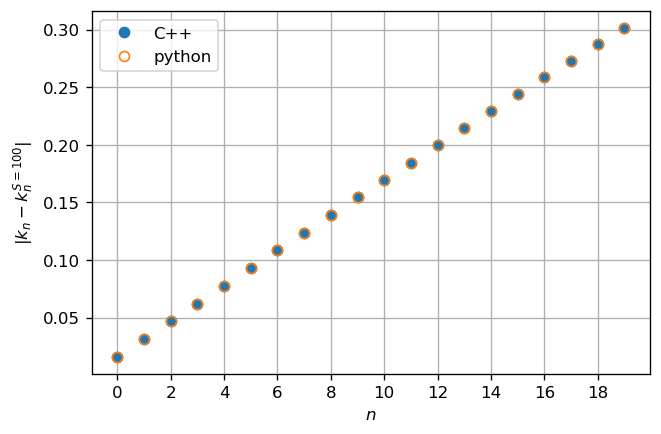

In [4]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(dpi=120)
ax = fig.gca()
n = range(len(coeffs_cpp['Kn']))

ax.grid()
ax.set_xlabel('$n$')
ax.set_ylabel('$|k_n-k_n^{S=' + str(100) + '}|$')
ax.plot(n, abs(np.array(coeffs_cpp['Kn'])-np.array(apa_coeffs['noSlip']['Kn'])), linestyle='', marker='o', label='C++')
ax.plot(n, abs(np.array(coeffs_python['Kn'])-np.array(apa_coeffs['noSlip']['Kn'])), linestyle='', marker='o', markerfacecolor='none', label='python')
ax.set_xticks(n[::2])
ax.legend();
fig.savefig(os.path.join(fig_dir, "knComp.pdf"))

# Figure 5

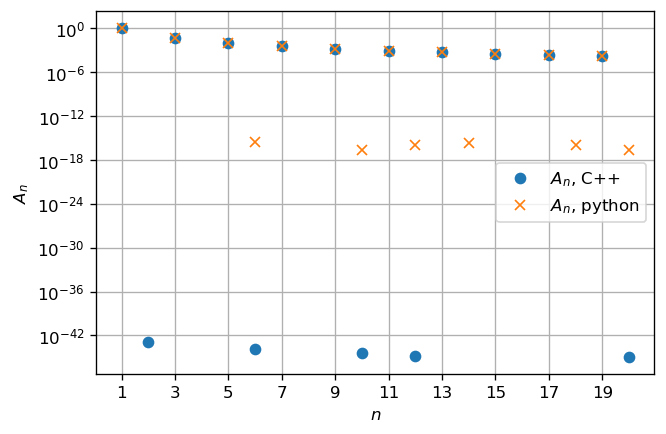

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=120)
ax = fig.gca()

ax.grid()
ax.set_xlabel('$n$')
ax.set_ylabel('$A_n$')
coeff_n = range(1,len(coeffs_cpp['An'])+1)
ax.semilogy(coeff_n, coeffs_cpp['An'], linestyle='', marker='o', label='$A_n$, C++' )
ax.semilogy(coeff_n, coeffs_python['An'], linestyle='', marker='x', markerfacecolor='none', label='$A_n$, python')
ax.set_xticks(n[1::2])
ax.legend();
fig.savefig(os.path.join(fig_dir, "anComp.pdf"))

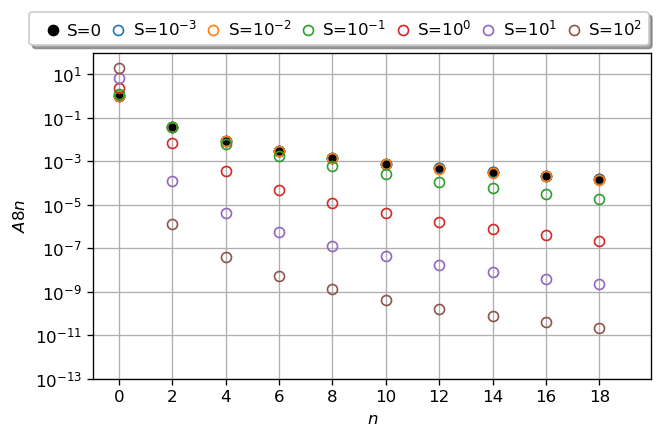

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(dpi=120)
ax = fig.gca()

ax.grid()
ax.set_xlabel('$n$')
ax.set_ylabel('')
powers = range(-3,3,1)
Slist = np.power(10.0,powers)

ax.semilogy(n, apa_coeffs['noSlip']['An'], linestyle='', marker='o', color='black', label='S=0')

for S,strPow in zip(Slist, powers):
    coeffs = cf.StartupCoefficients_scaled()
    Kn = coeffs.Kn(S, N, tol_py, eps_py)
    An = coeffs.An(S, Kn) # depends on Kn

    ax.set_xlabel("$n$")
    ax.set_ylabel("$A8n$")
    ax.semilogy(n, An, linestyle='', marker='o', markerfacecolor='none', label='S=' + toExpStr(strPow))
    
ax.set_ylim([1e-13,1e2])
ax.set_xticks(n[0::2])
ax.legend();
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.44, 1.15),
          fancybox=True, shadow=True, ncol=len(Slist)+1, columnspacing=0.0, handletextpad=-0.15)
fig.savefig(os.path.join(fig_dir, "sAnComp.pdf"))

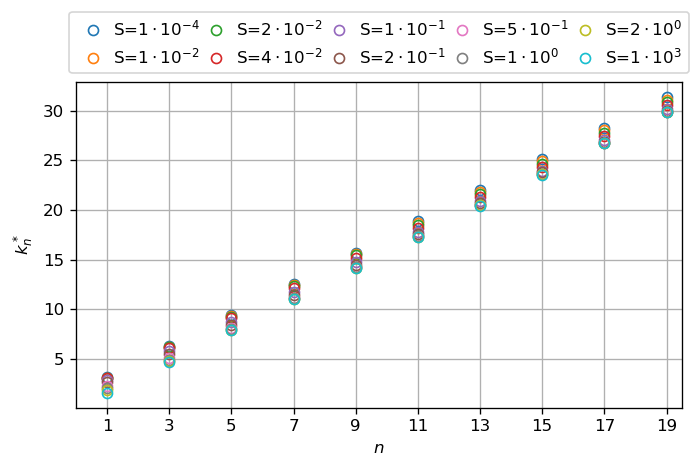

In [7]:
import numpy as np
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if np.isclose(0.0,num):
        return r'$0.0$'
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}n}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

#print("number" + str(sci_notation(1e-04)))
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(dpi=120)
fig.set_tight_layout(True)
ax = fig.gca()

ax.grid()
ax.set_xlabel('$n$')
ax.set_ylabel('')
Slist = [10**-4, 10**-2, 2*10**-2, 4*10**-2, 10**-1, 2*10**-1, 5*10**-1, 10**0, 2*10**0, 10**3]
x_plot = np.arange(0,2*n[-1],10)
for S in Slist:
    coeffs = cf.StartupCoefficients_scaled()
    Kn = coeffs.Kn(S, N, tol_py, eps_py)
    Kn_plot = np.array(Kn)
    
    ax.set_xlabel("$n$")
    ax.set_ylabel("$k^*_n$")
    ax.plot(n[1:20:2], Kn_plot[1:20:2], linestyle='', marker='o', markerfacecolor='none', label='S=' + sci_notation(S))
    ax.set_xlim([n[0], n[-1]+0.5])
    ax.set_xticks(n[1:20:2])
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5,1.0), \
          fancybox=True, shadow=False, ncol=5, columnspacing=0.0, handletextpad=0.2)
fig.savefig(os.path.join(fig_dir, "sKnComp.pdf"))

# Figure 9

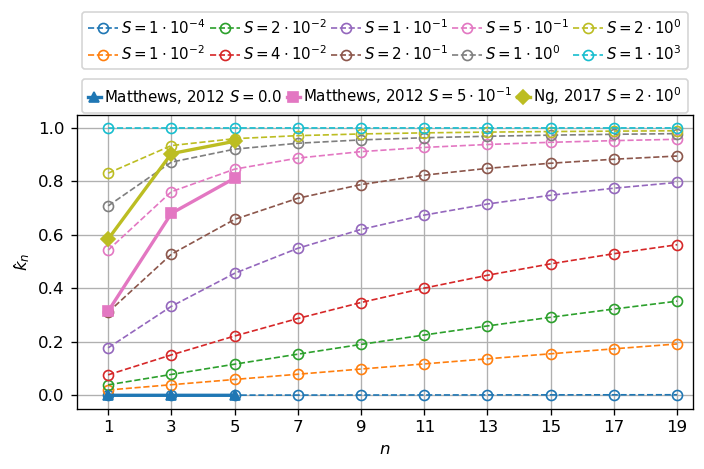

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(dpi=120)
fig.set_tight_layout(True)
ax = fig.gca()

lines_numeric = []
lines_numeric_labels = []
lines_papers = []
lines_papers_labels = []
def scale_kn(kn, kn_no_slip):
    kn_scaled = (np.array(kn) - np.array(kn_no_slip))/(-np.pi/2.0)
    return kn_scaled

# plot python startup coefficients
for S in Slist:
    # compute and scale the data
    coeffs = cf.StartupCoefficients_scaled()
    Kn =  coeffs.Kn(S, N, tol_py, eps_py)
    Kn_plot = scale_kn(Kn, apa_coeffs['noSlip']['Kn'])
    lines_numeric += ax.plot(n[1:20:2], Kn_plot[1:20:2], \
            linewidth=1.0, linestyle='--', marker='o', \
            markerfacecolor='none')
    lines_numeric_labels.append('$S=' + sci_notation(S).lstrip('$'))
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lit_colors = [colors[i] for i in [0,6,8]]
    
# plot literature values
index=0
markers = ['^','s','D']
for paper_name, paper in lit.items():
    for slipLength, coeffs in paper.items():
        n_coeffs = len(coeffs['kn'])
        kn_scaled = scale_kn(coeffs['kn'], apa_coeffs['noSlip']['Kn'][:n_coeffs])
        
        lines_papers += ax.plot(n[1:n_coeffs+1:2], kn_scaled[::2], \
                linewidth=2,linestyle='-', marker=markers[index], \
                color=lit_colors[index])#, \
        lines_papers_labels.append(paper_name + ' $S=' + sci_notation(slipLength).lstrip('$'))
        index = index+1

ax.grid()
ax.set_xlabel('$n$')
ax.set_ylabel('')
ax.set_xlabel("$n$")
ax.set_ylabel("$k\u0302_n$")
ax.set_xlim([n[0],n[-1]+0.5])
ax.set_xticks(n[1:20:2])

# specify the lines and labels of the first legend
ax.legend(lines_numeric, lines_numeric_labels,
          loc='lower center', bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=False, ncol=5, columnspacing=0.3, handletextpad=0.2, prop={'size': 9})

# Create the second legend and add the artist manually.
from matplotlib.legend import Legend
leg = Legend(ax, lines_papers, lines_papers_labels,
          loc='lower center', bbox_to_anchor=(0.5, 0.98),
          fancybox=True, shadow=False, ncol=5, columnspacing=0.3, handletextpad=0.2,
            handlelength=0.9, prop={'size': 9})
ax.add_artist(leg);

fig.savefig(os.path.join(fig_dir, "sKnComp_scaled.pdf"))